In [5]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Using TensorFlow backend.


Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [6]:
# %load SM
#!/usr/bin/env python

# In[ ]:


#load the data
def load_data(filename, window_length,percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape

    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore

def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    
    model.add(LSTM(units = 32, return_sequences = True))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 32, activation='relu'))
    
    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1,activation='linear'))
   
    
              
    model.compile(optimizer =optimizer, loss = loss)

    
    return model

#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    history=model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model,history

# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("EOS Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore

#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in EOS Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0

def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg



(396, 30, 98)
(396,)
(180, 30, 98)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            16768     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_15 (LSTM)          

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 316 samples, validate on 80 samples
Epoch 1/100
316/316 [==============================] - 4s 11ms/step - loss: 0.1252 - val_loss: 0.0046
Epoch 2/100
316/316 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0066
Epoch 3/100
316/316 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0038
Epoch 4/100
316/316 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0038
Epoch 5/100
316/316 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0041
Epoch 6/100
316/316 [==============================] - 0s 978us/step - loss: 0.0211 - val_loss: 0.0038
Epoch 7/100
316/316 [==============================] - 0s 950us/step - loss: 0.0215 - val_loss: 0.0039
Epoch 8/100
316/316 [==============================] - 0s 969us/step - loss: 0.0195 - val_loss: 0.0039
Epoch 9/100
316/316 [==============================] - 0s 941us/step - loss: 0.0220 - val_loss: 0.0042
Epoch 10/100
316/316 [===============

Epoch 80/100
316/316 [==============================] - 0s 945us/step - loss: 0.0198 - val_loss: 0.0068
Epoch 81/100
316/316 [==============================] - 0s 947us/step - loss: 0.0191 - val_loss: 0.0067
Epoch 82/100
316/316 [==============================] - 0s 953us/step - loss: 0.0195 - val_loss: 0.0058
Epoch 83/100
316/316 [==============================] - 0s 956us/step - loss: 0.0194 - val_loss: 0.0067
Epoch 84/100
316/316 [==============================] - 0s 928us/step - loss: 0.0192 - val_loss: 0.0062
Epoch 85/100
316/316 [==============================] - 0s 950us/step - loss: 0.0197 - val_loss: 0.0068
Epoch 86/100
316/316 [==============================] - 0s 969us/step - loss: 0.0185 - val_loss: 0.0068
Epoch 87/100
316/316 [==============================] - 0s 934us/step - loss: 0.0191 - val_loss: 0.0068
Epoch 88/100
316/316 [==============================] - 0s 925us/step - loss: 0.0191 - val_loss: 0.0109
Epoch 89/100
316/316 [==============================] - 0s 953us

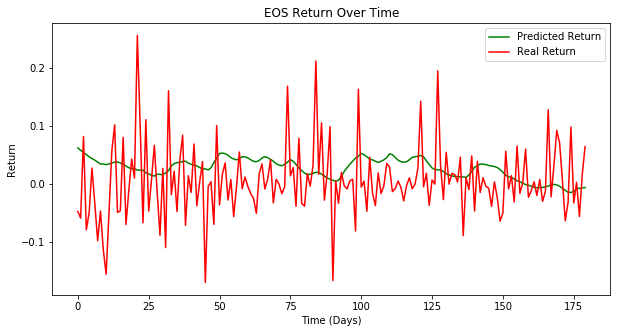

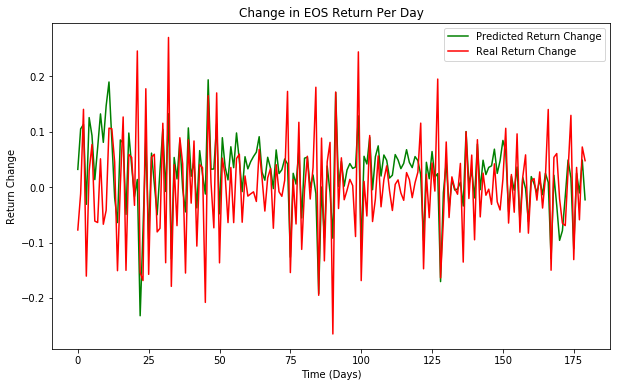

true positive is 87
false positive is 41
true negative is 45
false negative is 7
precision rate is 0.6797
accuracy rate is 0.7333
recall rate is 0.9255
F1 Score is 0.7838


In [18]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_EOS-USD.csv", 30, 0.6880)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model= fit_model(model, X_train, Y_train, 32, 100, .2)

#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

In [20]:
model_lstm=model
test_X= X_test
train_X=X_train
stock_context_fs=dataset_total
# Get the predicted price
predicted_y_lstm = model_lstm.predict(test_X, batch_size=None, verbose=0, steps=None)
# Get the trained price
trained_y_lstm = model_lstm.predict(train_X, batch_size=None, verbose=0, steps=None)
# Vertically stack trained and predicted price into a dataframe to form a vector of price produced by CNN


NameError: name 'split_line' is not defined

In [1]:
#ETH
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_ETH-USD.csv", 30, 0.8582)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

NameError: name 'load_data' is not defined

(1740, 30, 108)
(1740,)
(180, 30, 108)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_8 (LSTM)                (None, 30, 32)            8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 30, 32)            1056      
_________________________________________________________________
lstm_9 (LSTM)       

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1392 samples, validate on 348 samples
Epoch 1/100
1392/1392 [==============================] - 31s 22ms/step - loss: 0.0128 - val_loss: 9.5543e-04
Epoch 2/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 3/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0028 - val_loss: 8.3934e-04
Epoch 4/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0025 - val_loss: 9.6583e-04
Epoch 5/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0022 - val_loss: 8.7412e-04
Epoch 6/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0021 - val_loss: 8.1927e-04
Epoch 8/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0021 - val_loss: 8.7502e-04
Epoch 9/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0022 - val_loss: 0.0011


1392/1392 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 80/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0088
Epoch 81/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0107
Epoch 82/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 83/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0014 - val_loss: 0.0179
Epoch 84/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 85/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0128
Epoch 86/100
1392/1392 [==============================] - 4s 3ms/step - loss: 0.0013 - val_loss: 0.0095
Epoch 87/100
1392/1392 [==============================] - 5s 3ms/step - loss: 0.0013 - val_loss: 0.0165
Epoch 88/100
1392/1392 [==============================] - 5s 3ms/step - loss:

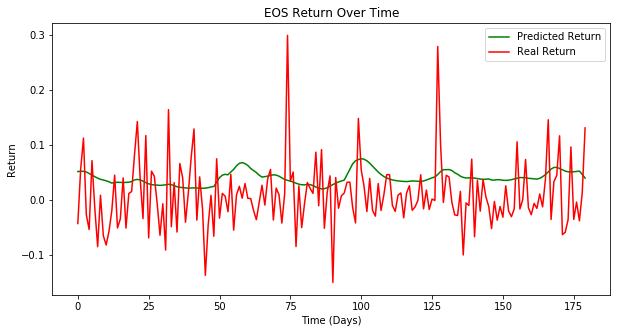

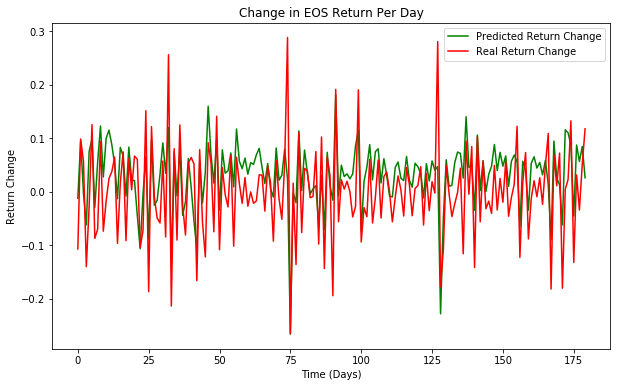

true positive is 88
false positive is 51
true negative is 36
false negative is 5
precision rate is 0.6331
accuracy rate is 0.6889
recall rate is 0.9462
F1 Score is 0.7586


In [5]:
#LTC

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_LTC-USD.csv", 30 ,0.9063)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(640, 30, 112)
(640,)
(180, 30, 112)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30, 32)            18560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_12 (LSTM)        

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 448 samples, validate on 192 samples
Epoch 1/100
448/448 [==============================] - 23s 51ms/step - loss: 0.0353 - val_loss: 0.0041
Epoch 2/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0122 - val_loss: 0.0045
Epoch 3/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0101 - val_loss: 0.0050
Epoch 4/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0034
Epoch 5/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0033
Epoch 6/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0034
Epoch 7/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0033
Epoch 8/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0034
Epoch 9/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 0.0033
Epoch 10/100
448/448 [=====================

Epoch 81/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0079 - val_loss: 0.0048
Epoch 82/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 83/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 84/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0044
Epoch 85/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 86/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 87/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 88/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 89/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 90/100
448/448 [==============================] - 1s 2ms/step - loss: 0.0077

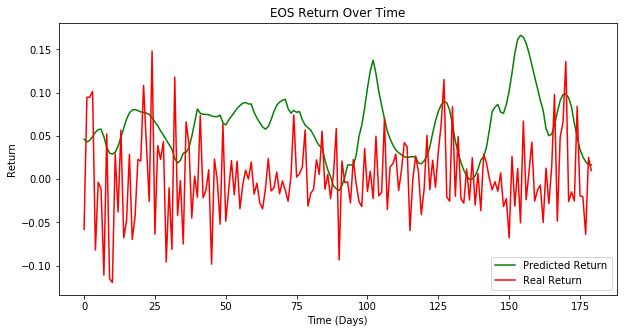

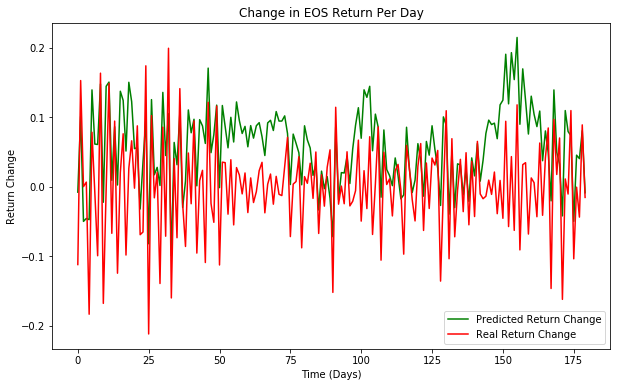

true positive is 92
false positive is 59
true negative is 26
false negative is 3
precision rate is 0.6093
accuracy rate is 0.6556
recall rate is 0.9684
F1 Score is 0.748


In [6]:
#ZEC

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_ZEC-USD.csv", 30 ,0.7808)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1286, 30, 110)
(1286,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            18304     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_14 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_15 (LSTM)      

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 386 samples
Epoch 1/100
900/900 [==============================] - 24s 26ms/step - loss: 0.0121 - val_loss: 0.0019
Epoch 2/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 3/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 4/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 5/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 6/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 7/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 9/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 10/100
900/900 [=====================

Epoch 81/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 82/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 83/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 84/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 85/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 86/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 87/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 88/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 89/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 90/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0030

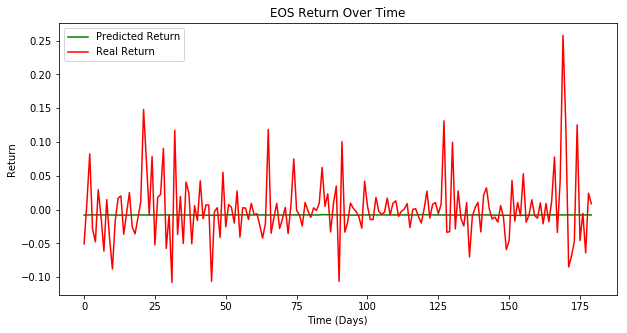

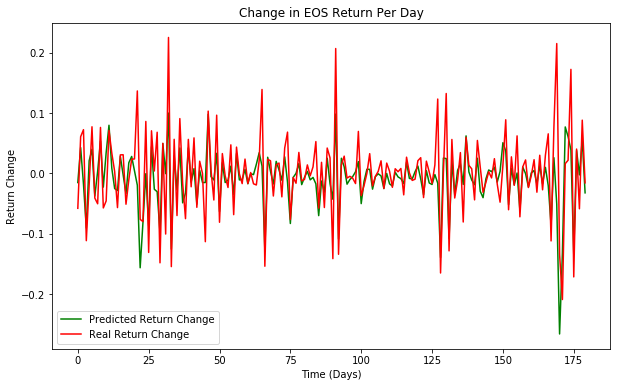

true positive is 66
false positive is 12
true negative is 73
false negative is 29
precision rate is 0.8462
accuracy rate is 0.7722
recall rate is 0.6947
F1 Score is 0.763


In [7]:
#XRP

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_XRP-USD.csv", 30 ,0.8773)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2934, 30, 73)
(2934,)
(180, 30, 73)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 30, 32)            13568     
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
lstm_18 (LSTM)        

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:124: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2053 samples, validate on 881 samples
Epoch 1/100
2053/2053 [==============================] - 6s 3ms/step - loss: 0.0020 - val_loss: 3.4365e-04
Epoch 2/100
2053/2053 [==============================] - 2s 968us/step - loss: 9.7118e-04 - val_loss: 4.6698e-04
Epoch 3/100
2053/2053 [==============================] - 2s 986us/step - loss: 8.8557e-04 - val_loss: 3.3259e-04
Epoch 4/100
2053/2053 [==============================] - 2s 911us/step - loss: 8.3573e-04 - val_loss: 4.8362e-04
Epoch 5/100
2053/2053 [==============================] - 2s 1ms/step - loss: 8.0137e-04 - val_loss: 6.0121e-04
Epoch 6/100
2053/2053 [==============================] - 2s 1ms/step - loss: 8.3110e-04 - val_loss: 2.5420e-04
Epoch 7/100
2053/2053 [==============================] - 2s 1ms/step - loss: 7.6185e-04 - val_loss: 3.4414e-04
Epoch 8/100
2053/2053 [==============================] - 2s 1ms/step - loss: 7.8302e-04 - val_loss: 2.4733e-04
Epoch 9/100
2053/2053 [==============================] - 2s 1ms

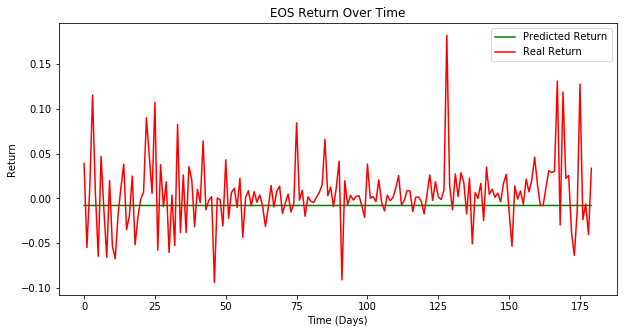

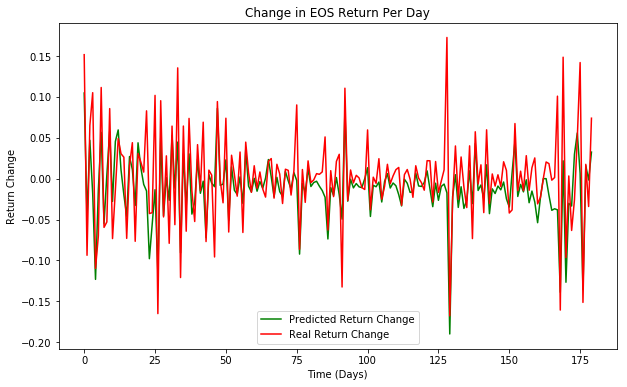

true positive is 46
false positive is 6
true negative is 78
false negative is 50
precision rate is 0.8846
accuracy rate is 0.6889
recall rate is 0.4792
F1 Score is 0.6216


In [8]:
#Bitcoin

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin_revised.csv", 30 ,0.9422)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))